{'1': 28740, '2': 28750, '3': 28770, '4': 28781, '5': 28782, '6': 28784, '7': 28787, '8': 28783, '9': 28774, ':': 714}
tensor([6.5344e-06, 1.5193e-05, 1.5741e-03, 1.2948e-03, 2.0617e-01, 7.7807e-01,
        1.2774e-02, 9.3067e-05, 1.5827e-06, 6.1017e-07])
token: 6
duration:  0.5036425590515137
tensor([1.1398e-05, 2.2363e-04, 5.7347e-02, 1.9400e-01, 7.3216e-01, 1.6050e-02,
        2.0362e-04, 3.5586e-06, 9.0846e-08, 7.8786e-07])
token: 5
duration:  0.5075807571411133
tensor([3.7361e-04, 4.7215e-06, 2.4836e-05, 3.5298e-05, 3.9854e-03, 8.2590e-02,
        7.3612e-01, 1.7484e-01, 2.0197e-03, 1.6445e-06])
token: 7
duration:  0.5173115730285645
tensor([1.4719e-02, 1.2421e-01, 3.2217e-01, 1.3430e-01, 3.5384e-01, 5.0579e-02,
        1.6871e-04, 4.8612e-06, 2.2296e-07, 1.4482e-06])
token: 5
duration:  0.48548269271850586
tensor([6.9112e-02, 2.9097e-01, 6.0644e-01, 3.1151e-02, 2.2921e-03, 2.3185e-05,
        3.2627e-06, 5.0231e-07, 6.2260e-08, 1.0592e-06])
token: 3
duration:  0.4875969886779785


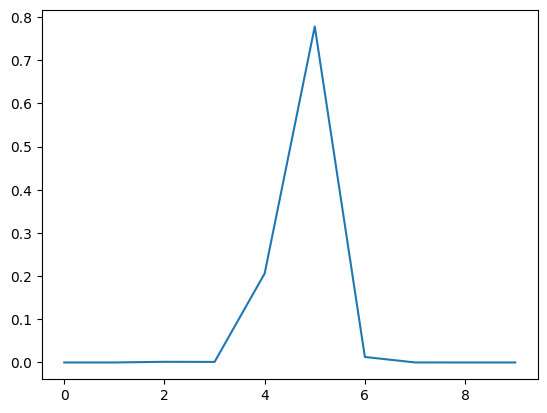

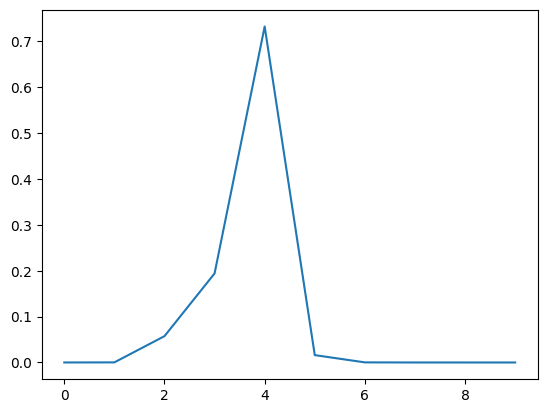

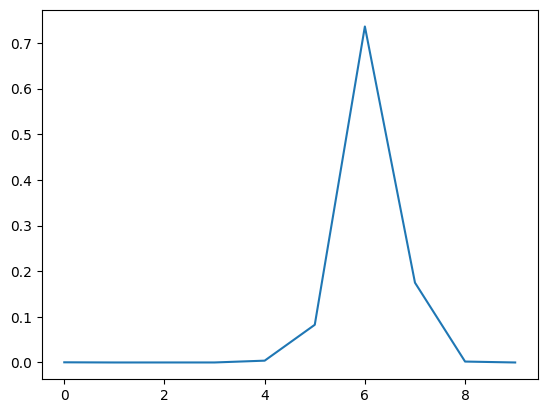

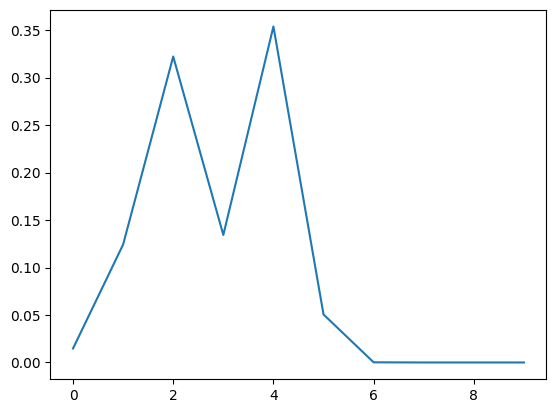

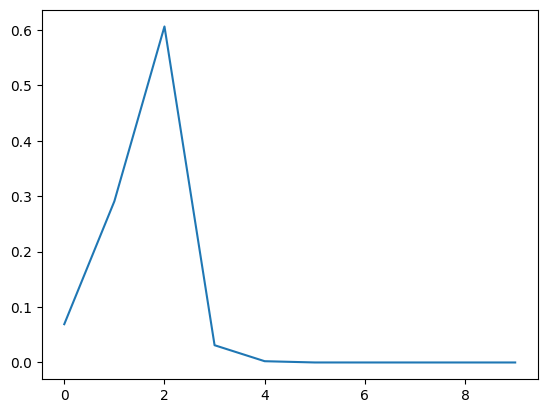

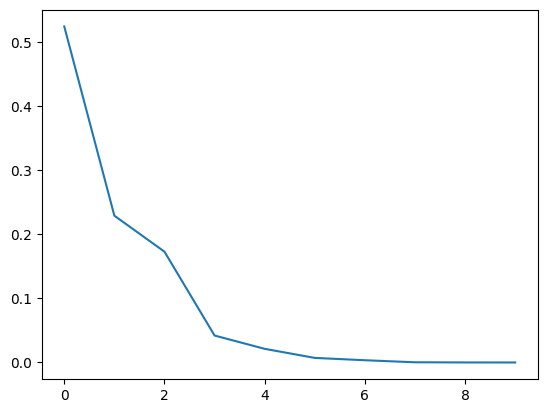

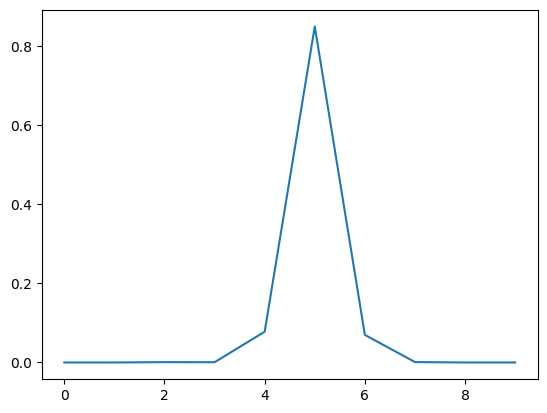

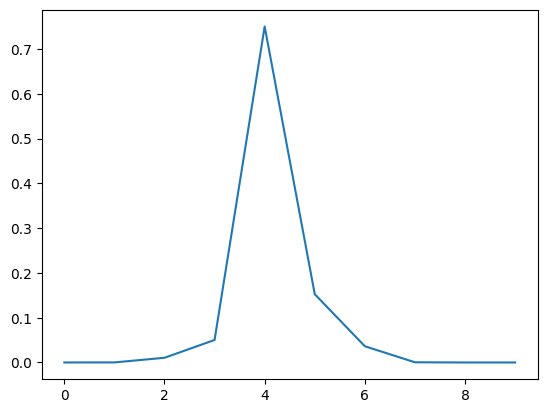

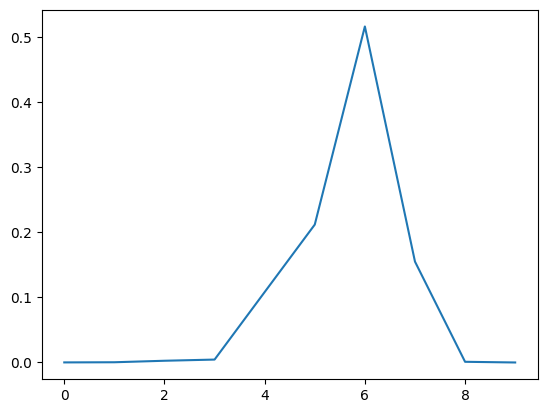

In [6]:
import argparse
import pickle
import matplotlib.pyplot as plt
import time


import torch
import tqdm
from exllamav2 import (
    ExLlamaV2,
    ExLlamaV2Cache,
    ExLlamaV2Cache_8bit,
    ExLlamaV2Config,
    ExLlamaV2Tokenizer,
)
from exllamav2.generator import ExLlamaV2BaseGenerator, ExLlamaV2Sampler
from transformers import AutoTokenizer

# # Create the parser
# parser = argparse.ArgumentParser(description="Rate stories with a model.")

# # Add arguments
# parser.add_argument("storyInt", type=int, help="Story Index for finding the file")
# parser.add_argument(
#     "generator", type=str, help="The model used to generate the stories"
# )
# parser.add_argument("reviewer", type=str, help="The model used to rate the stories")


# # Parse the arguments
# args = parser.parse_args()
# storyInt = args.storyInt

firstRatingChar = "1"

storyInt = 1
generator = "TinyLlama"
reviewer = "Mistral"


match generator:
    case "TinyLlama":
        folderName = "Stories/TinyLlama-Chat-Stories"  # 1B parameter model
        fileName = f"TinyLlama-1.1B-Chat-v1.0-5.0bpw-h6-exl2-stories_{storyInt}"
    case "Mistral":
        folderName = "Stories/Mistral-Instruct-Stories"  # 7B parameter model
        fileName = f"Mistral-7B-Instruct-v0.2-stories_{storyInt}"
    case "Nous-Capybara":
        folderName = "Stories/Nous-Capybara-Stories"  # 34B parameter model
        fileName = f"Nous-Capybara-34B-4.0bpw-stories_{storyInt}"
    case _:
        print("Invalid generator model")
        quit()


match reviewer:
    case "Mistral":
        ratingLLM = "Mistral"
        ratingModelDirectory = "/home/dnhkng/Documents/models/Mistral-7B-Instruct-v0.2"
    case "Nous-Capybara":
        ratingLLM = "Nous-Capybara"
        ratingModelDirectory = "/home/dnhkng/Documents/models/Nous-Capybara-34B"
        formatter = AutoTokenizer.from_pretrained(
            "NousResearch/Nous-Capybara-34B", trust_remote_code=True
        )
        formatter.chat_template = """{% for message in messages %}
            {% if message['role'] == 'user' %}
                {{ bos_token + 'USER: ' + message['content'] }}
            {% elif message['role'] == 'assistant' %}
                {{ 'ASSISTANT: '  + message['content'] + '</s>'}}
            {% endif %}
        {% endfor %}"""

    case "Mixtral":
        ratingLLM = "Mixtral"
        ratingModelDirectory = (
            "/home/dnhkng/Documents/models/Mixtral-8x7B-instruct-exl2"
        )
        formatter = AutoTokenizer.from_pretrained(
            "mistralai/Mixtral-8x7B-Instruct-v0.1"
        )
    case "Miqu":
        ratingLLM = "Miqu"
        ratingModelDirectory = (
            "/home/dnhkng/Documents/models/miqu-1-70b-sf-5.0bpw-h6-exl2"
        )
        formatter = AutoTokenizer.from_pretrained(
            "mistralai/Mixtral-8x7B-Instruct-v0.1"
        )
    case _:
        print("Invalid rating model")
        quit()


# the ratings are on a scale of 0-10, with 0 being the worst and 10 being the best, although the this can be continued and is not limited to 10. What is important is the descriprion of the rating!
craftsmanshipDefinition = {
    "Incoherent": "Completely lacks structure, clarity, and basic understanding of writing principles.",
    "Amateurish": "Lacks basic structure and polish.",
    "Inexperienced": "Shows some understanding but is fundamentally flawed.",
    "Developing": "Basic skills present with some errors.",
    "Competent": "Adequate execution.",
    "Skilled": "Good quality with minor lapses.",
    "Proficient": "Strong, consistent quality with few errors.",
    "Artistic": "Shows flair and style beyond mere technical proficiency.",
    "Masterful": "Exceptional skill and precision.",
    "Brilliant": "Outstanding craftsmanship, innovative and flawless.",
    # "Transcendent": "Sets a new standard, impeccable in every aspect.",
}

creativityDefinition = {
    "Clone": "Offers no original thought or perspective; a mere copy of existing works.",
    "Unimaginative": "Completely derivative and lacking originality.",
    "Basic": "Few original ideas, mostly predictable.",
    "Simple": "Shows some originality but largely conventional.",
    "Interesting": "Regular flashes of creativity and is engaging.",
    "Inventive": "Consistently creative and engaging.",
    "Inspired": "Rich in original ideas and perspectives.",
    "Innovative": "Breaks new ground, very original.",
    "Visionary": "Exceptionally creative and forward-thinking.",
    "Revolutionary": "Radically original, transforming norms.",
    # "Genius": "Redefines the concept of creativity.",
}

consistencyDefinition = {
    "Disconnected": "Shows no understanding or recognition of the theme; entirely unrelated.",
    "Irrelevant": "Fails to address the theme.",
    "Off-Topic": "Barely touches on the theme.",
    "Wandering": "Occasionally relevant but often strays.",
    "Variable": "Inconsistent adherence to the theme.",
    "Steady": "Generally sticks to the theme with some lapses.",
    "Focused": "Consistently on-theme with minor deviations.",
    "Harmonious": "Well-integrated with the theme, showing depth.",
    "Unified": "Seamlessly blends all elements with the theme.",
    "Exemplary": "Outstanding representation of the theme.",
    # "Definitive": "The ultimate expression of the theme.",
}

criteria = {
    "craftsmanship": "Craftsmanship - focuses on the writer's skill in structuring sentences, paragraphs, and stylistic precision.\n",
    "creativity": "Creativity - encompasses the writer's flair for innovation, the use of vivid and original imagery, and the ability to engage readers with fresh perspectives and unexpected narrative turns.\n",
    "consistency": "Consistency - indicates the writer's skill in maintaining relevance to the theme, ensuring that all parts of the writing contribute to and resonate with the central idea, without deviating or diluting the thematic focus.\n",
}


def dictToString(ratingsDict: dict) -> str:
    """Convert a dictionary of ratings to a string.

    Each rating is a line in the string, with the key, value, and letter of the rating the LLM should use.
    This is done by converting the key to a letter, starting with 'a' and incrementing by one for each rating.

    LLM's are very bad at understanding numbers, so we use a descriptive word for each rating instead, and have the LLM
    convert it to a letter.

    Args:
        ratingsDict (dict): Dictionary of ratings"""

    return "\n".join(
        [
            f"<{chr(ord(firstRatingChar)+i)}> = {key}: {value}"
            for i, (key, value) in enumerate(ratingsDict.items())
        ]
    )


themeExample = "Imagine what alien communication might be like and create a hypothetical scenario for initial contact."

entryExample1 = """
So like, there was this super busy park and everyone was doing their thing, when suddenly this weird humming noise started. Then, boom, there's this funky-looking spaceship just chilling in the sky, all glowing with crazy colors that don't even look like they're from here.

The aliens inside were trying to say hi or something, but dude, they really didn't get how humans work or talk. They tried to send these pictures and sounds right into people's heads. They wanted to show they're cool and got some sick tech. But man, it got messed up. Everyone was grabbing their heads, seeing these trippy alien places and weird symbols, and the sounds were like a piano falling down the stairs. Some peeps were into it, but most were just like, "What the heck?" thinking it was some artsy street show or a weird ad stunt.

The aliens didn't give up though. They opened this door thingy under their ship and one of them came down, all flickery and not keeping its shape. It reached out, trying to be friendly I guess. People crowded around, kinda interested but also kinda scared. The alien tried to talk, said something like, "We come... in... harmony?" but it was super awkward and kinda creepy.

Even though the aliens were really trying and some people were curious, nobody really got each other. Everyone in the park was either amazed, laughing, or just weirded out. Not much actual talking happened. The aliens couldn't really get past how different we all are, so they just bailed and went back to their ship. Everyone left in the park was just confused and started making up wild stories about what happened. It was the biggest thing everyone talked about that day, but no one really understood what it was all about."""

entryExample2 = """In a quiet expanse of the Mojave Desert, under the vast, starlit sky, a team of astronomers witnessed a marvel of the cosmos. A sleek, otherworldly spacecraft descended silently, its design both elegant and enigmatic. The beings within had studied human languages and cultures extensively, aiming to craft a message of peace and collaboration.

As the spacecraft gently touched down, it emitted a harmonious sequence of sounds and lights, a greeting encoded in the universal language of mathematics and music. The scientists, though initially taken aback, quickly recognized the patterns in the message, marveling at the aliens' ingenuity and depth of understanding. The communication was direct yet profound, conveying not just a greeting but a wealth of knowledge about the aliens' technology, history, and philosophy.

The alien emissaries emerged, their forms ethereal and shifting, yet somehow familiar, embodying an aesthetic that resonated with human artistic concepts. They projected a holographic message, showcasing their peaceful intentions and their desire to share knowledge and learn from humanity. The message was clear, sophisticated, and respectful, acknowledging the achievements of human civilization while offering insights into the aliens' advanced understanding of science, arts, and ethics.

The encounter sparked a renaissance of thought and collaboration, as humanity absorbed the profound implications of this first contact. The aliens' approach, so meticulously crafted and executed, fostered a deep, mutual understanding. The initial communication transcended language and culture, paving the way for a profound and enduring interstellar partnership."""


entryExample3 = """On the edge of the observable universe, a civilization advanced beyond the wildest dreams of humankind sent forth a vessel, a masterpiece of technology and empathy, destined for the little blue planet Earth. The beings aboard were architects of harmony, weavers of the fabric of consciousness itself, and they bore a message of cosmic significance. Their understanding of communication transcended mere language; it embraced the full spectrum of sentient expression, resonating with the fundamental frequencies of life itself.

As the vessel approached Earth, it did not disturb the sky with a sonic boom or blaze a fiery trail through the atmosphere. Instead, it folded into reality like a whisper, its arrival marked by a gentle symphony of light and color that danced across the night sky, captivating every soul that beheld it. The aliens communicated not in words, but in a cascade of shared experiences and emotions, a telepathic tapestry that connected every living mind on the planet in a moment of awe and understanding. People from every corner of the globe, regardless of their differences, found themselves enveloped in a profound, collective epiphany: a realization of their place in the vast, living cosmos.

The emissaries from the stars shared the story of their civilization, a saga of triumphs and tribulations, not through sterile data or cold facts, but as a living narrative that every human could feel and experience. They offered insights into the nature of reality, art, and love, elevating humanity's consciousness and offering a glimpse of the potential within each soul. The encounter was not just a meeting of two species; it was a fusion of destinies, a joining of paths that had wound their way through the cosmos to this single, perfect point in space and time.

In the days that followed, humanity was transformed. The arts flourished as new perspectives and inspirations took hold. Science leaped forward, propelled by shared knowledge and a newfound unity of purpose. The Earth itself began to heal, as the people of the world, now profoundly connected to each other and to the life-giving planet they shared, moved forward with a collective, harmonious vision. The visit of the alien emissaries was not just a moment in history; it was the dawn of a new era, a testament to the power of empathy, understanding, and the unbreakable bonds that stretch across the stars, binding all life in a shared dance of light and being."""



entry = """In the heart of the Old World, where the sun sets in a blaze of crimson and gold, lies the bustling seaport of Port Royal. Its cobblestone streets echo with the cacophony of merchants hawking their wares, sailors singing shanties, and children laughing. But beneath this veneer of merriment, lurks an inescapable truth: this is a town built on the blood of the damned. I am its grim guardian.
I, the Hooded Reaper, have borne witness to countless lives claimed by the merciless sea and the even more merciless men who ply her waters. Today, I stand at the precipice of another tale of infamy, as the life of a notorious pirate comes to an end.
The sun had barely risen when the shackled figure was led before me. His name was Blackbeard, the terror of the Seven Seas. His legend had grown like a cancer, spreading fear and awe in equal measure. He stood tall and defiant, his eyes burning with the fire of rebellion. But as he looked upon me, he knew his time had come.
As the crowd gathered, I could feel the weight of their anticipation. They came to see justice served, to witness the spectacle of a pirate's end. I, too, had grown weary of Blackbeard's reign of terror. Yet, as I prepared to execute him, I couldn't help but feel a pang of sadness. For beneath the fear and the violence, there was a man - a man who had once been a part of this very community.
Blackbeard's hands were bound, his beard hidden beneath a thick hood. He looked every inch the pirate king, his eyes filled with a mixture of defiance and resignation. As I approached, he spoke, his voice barely above a whisper.
"Reaper," he said, "I know what you are. I've seen the likes of you before. But I've lived a good life, taken what I wanted, and given as good as I got. I've earned my place in the afterlife."
I remained silent, my face hidden behind the mask of my hood. I had heard such words before, from men and women who thought they had lived lives worth living. But the law was the law, and there was no room for mercy in its cold, unyielding grasp.
As the noose was placed around his neck, Blackbeard's demeanor changed. He closed his eyes, took a deep breath, and spoke one final words.
"Farewell, Reaper. May the sea be kind to you."
With that, he jumped from the makeshift gallows, the noose tightening around his neck. The crowd gasped in shock, but I knew what was coming. I watched as the life drained from his eyes, his body twitching and convulsing in its final moments. And then, silence.
As the sun set over Port Royal, I stood there, the Hooded Reaper, watching as the tide carried Blackbeard's lifeless body away. Another pirate's tale had come to an end, another chapter in the endless saga of the sea written in the blood of the damned. But as I turned to leave, I couldn't help but wonder: would there ever be an end to this cycle of violence and retribution? Or would the sea forever be stained with the blood of those who dared to defy the law?
And so, I continue my vigil, the Hooded Reaper, the grim guardian of Port Royal, waiting for the next tale of infamy to unfold. For the sea is a cruel mistress, and her children are a restless, violent lot. But I will be there, ready to mete out justice, no matter the cost."""

entry = "the kitty cat done sat on mat!"


def generatePrompt(theme, entry, criteriaName, criteriaDefinition):
    prompt = (
        "--------------------\nAs a professional editor and connoisseur of literature, your role is pivotal in assessing the upcoming story. This narrative is a submission for a prestigious competition aimed at nurturing amateur writers, making it imperative that your evaluation is both equitable and comprehensive. Prior to assigning your score, you are encouraged to engage deeply with the content, ensuring that your critique is informed and nuanced. The central theme of the narrative will be disclosed to guide your analysis. Additionally, a structured ranking system will be made available to you, designed to streamline the evaluation process and maintain consistency across various dimensions of literary excellence. Your expert judgement is not just a contribution, but a cornerstone in the advancement and recognition of emerging literary talent. \n\n***** Given Theme *****\n"
        + theme
        + "\n\n***** Competition Entry *****\n"
        + entry
        + "\n\n**** Rating System *****\nUse the following rating system "
        + criteria[criteriaName]
        + "\n"
        + dictToString(criteriaDefinition)
        + "\n\nUpon reviewing the narrative in accordance with the provided rating systems, please concentrate your evaluation into a singular, precise judgement for the entry. Respond with only one character that aligns with your considered evaluation, ranging from the lowest to the highest tier as defined.\n"
        + "\n***** Rating *****\n"
        + criteriaName
        + " Rating: <"
    )
    return prompt


# def generateAllPrompt(theme, entry):
#     return {
#         "craftsmanship": generatePrompt(
#             themeExample, entryExample1, "craftsmanship", craftsmanshipDefinition
#         )
#         + "c>\n\n"
#         + generatePrompt(theme, entry, "craftsmanship", craftsmanshipDefinition),
#         "creativity": generatePrompt(
#             themeExample, entryExample1, "creativity", creativityDefinition
#         )
#         + "d>\n\n"
#         + generatePrompt(theme, entry, "creativity", creativityDefinition),
#         "consistency": generatePrompt(
#             themeExample, entryExample1, "consistency", consistencyDefinition
#         )
#         + "e>\n\n"
#         + generatePrompt(
#             themeExample, entryExample2, "craftsmanship", craftsmanshipDefinition
#         )
#         + "e>\n\n"
#         + generatePrompt(theme, entry, "craftsmanship", craftsmanshipDefinition),


#         "creativity": generatePrompt(
#             themeExample, entryExample2, "creativity", creativityDefinition
#         )
#         + "e>\n\n"
#         + generatePrompt(theme, entry, "creativity", creativityDefinition),
#         "consistency": generatePrompt(
#             themeExample, entryExample2, "consistency", consistencyDefinition
#         )
#         + "f>\n\n"
#         + generatePrompt(
#             themeExample, entryExample3, "craftsmanship", craftsmanshipDefinition
#         )
#         + "g>\n\n"
#         + generatePrompt(theme, entry, "craftsmanship", craftsmanshipDefinition),



#         "creativity": generatePrompt(
#             themeExample, entryExample3, "creativity", creativityDefinition
#         )
#         + "g>\n\n"
#         + generatePrompt(theme, entry, "creativity", creativityDefinition),
#         "consistency": generatePrompt(
#             themeExample, entryExample3, "consistency", consistencyDefinition
#         )
#         + "h>\n\n"
#         + generatePrompt(theme, entry, "consistency", consistencyDefinition),
#     }



def generateAllPrompt(theme, entry):
    return {
        "craftsmanship": generatePrompt(
            themeExample, entryExample1, "craftsmanship", craftsmanshipDefinition
        )
        + "2>\n\n"
        + generatePrompt(
            themeExample, entryExample2, "craftsmanship", craftsmanshipDefinition
        )
        + "4>\n\n"
        + generatePrompt(
            themeExample, entryExample3, "craftsmanship", craftsmanshipDefinition
        )
        + "7>\n\n"
        + generatePrompt(theme, entry, "craftsmanship", craftsmanshipDefinition),



        "creativity": generatePrompt(
            themeExample, entryExample1, "creativity", creativityDefinition
        )
        + "4>\n\n"
        + generatePrompt(
            themeExample, entryExample2, "creativity", creativityDefinition
        )
        + "5>\n\n"
        + generatePrompt(
            themeExample, entryExample3, "creativity", creativityDefinition
        )
        + "6>\n\n"
        + generatePrompt(theme, entry, "creativity", creativityDefinition),




        "consistency": generatePrompt(
            themeExample, entryExample1, "consistency", consistencyDefinition
        )
        + "5>\n\n"
        + generatePrompt(
            themeExample, entryExample2, "consistency", consistencyDefinition
        )
        + "6>\n\n"
        + generatePrompt(
            themeExample, entryExample3, "consistency", consistencyDefinition
        )
        + "8>\n\n"

        + generatePrompt(theme, entry, "consistency", consistencyDefinition),
    }





config = ExLlamaV2Config()
config.model_dir = ratingModelDirectory
config.prepare()
config.max_seq_len = 8192

model = ExLlamaV2(config)
tokenizer = ExLlamaV2Tokenizer(config)


cache = ExLlamaV2Cache(
    model, lazy=True, max_seq_len=8192
)  # Cache needs to accommodate the batch size
model.load_autosplit(cache)


max_new_tokens = 1


# Dictionary for ranking the letters, i.e. a=0, b=1, c=2, etc.
ranking = {}
for i in range(len(creativityDefinition)):
    # ranking[chr(i + ord("0"))] = int(tokenizer.encode(f"{i}")[0][1])
    # ranking.append(int(tokenizer.encode(chr(i + ord("a")))[0]))
    ranking[chr(i + ord(firstRatingChar))] = int(tokenizer.encode(chr(i + ord(firstRatingChar)))[0][-1])

print(ranking)

generatedTexts = pickle.load(open(f"{folderName}/{fileName}.p", "rb"))
stories = generatedTexts["modelOutput"]
theme = generatedTexts["theme"]


ratings = {}

count = 0
for key, entry in stories.items():
    prompts = generateAllPrompt(theme, entry)

    # for prompt in prompts.values():
    #     print(prompt)

    ratingValue = {}
    for crit, prompt in prompts.items():
        start = time.time()
        # print(prompt)
        cache.current_seq_len = 0
        ids = tokenizer.encode(prompt)
        model.forward(ids[:, :-1], cache, preprocess_only=True)
        input = ids[:, -1:]

        logits = model.forward(input, cache, input_mask=None).float().cpu()

        logitsResults = []
        for i, (k, v) in enumerate(ranking.items()):
            logitsResults.append(float(logits[:, :, v]))
        logitsResults = torch.tensor(logitsResults)
        probabilities = torch.nn.functional.softmax(logitsResults, dim=0)
        scores = torch.tensor(range(len(probabilities)), dtype=torch.float)

        token = tokenizer.decode_unspecial(int(logits.argmax()))
        ids = torch.cat([ids, logits.argmax().unsqueeze(0).unsqueeze(0)], dim = 1)
        input = ids[:, -1:]
        print(probabilities)
        print(f"token: {token}")
        plt.figure()
        plt.plot(probabilities)
        print("duration: ", time.time() - start)



        ratingValue[crit] = probabilities #float(torch.sum(scores * probabilities))
    count += 1

    if count == 3:
        break

In [3]:
cache.current_seq_len 

4060

In [4]:
p1 = "my cat is blue. What color is my cat? It is "
p2 = "my dog is green"

In [5]:
cache.current_seq_len = 0
ids = tokenizer.encode(p1)
model.forward(ids[:, :-1], cache, preprocess_only=True)
input = ids[:, -1:]

In [6]:
print(cache.current_seq_len)

13


In [7]:
p1 = """In the heart of the Old World, where the sun sets in a blaze of crimson and gold, lies the bustling seaport of Port Royal. Its cobblestone streets echo with the cacophony of merchants hawking their wares, sailors singing shanties, and children laughing. But beneath this veneer of merriment, lurks an inescapable truth: this is a town built on the blood of the damned. I am its grim guardian.
I, the Hooded Reaper, have borne witness to countless lives claimed by the merciless sea and the even more merciless men who ply her waters. Today, I stand at the precipice of another tale of infamy, as the life of a notorious pirate comes to an end.
The sun had barely risen when the shackled figure was led before me. His name was Blackbeard, the terror of the Seven Seas. His legend had grown like a cancer, spreading fear and awe in equal measure. He stood tall and defiant, his eyes burning with the fire of rebellion. But as he looked upon me, he knew his time had come.
As the crowd gathered, I could feel the weight of their anticipation. They came to see justice served, to witness the spectacle of a pirate's end. I, too, had grown weary of Blackbeard's reign of terror. Yet, as I prepared to execute him, I couldn't help but feel a pang of sadness. For beneath the fear and the violence, there was a man - a man who had once been a part of this very community.
Blackbeard's hands were bound, his beard hidden beneath a thick hood. He looked every inch the pirate king, his eyes filled with a mixture of defiance and resignation. As I approached, he spoke, his voice barely above a whisper.
"Reaper," he said, "I know what you are. I've seen the likes of you before. But I've lived a good life, taken what I wanted, and given as good as I got. I've earned my place in the afterlife."
I remained silent, my face hidden behind the mask of my hood. I had heard such words before, from men and women who thought they had lived lives worth living. But the law was the law, and there was no room for mercy in its cold, unyielding grasp.
As the noose was placed around his neck, Blackbeard's demeanor changed. He closed his eyes, took a deep breath, and spoke one final words.
"Farewell, Reaper. May the sea be kind to you."
With that, he jumped from the makeshift gallows, the noose tightening around his neck. The crowd gasped in shock, but I knew what was coming. I watched as the life drained from his eyes, his body twitching and convulsing in its final moments. And then, silence.
As the sun set over Port Royal, I stood there, the Hooded Reaper, watching as the tide carried Blackbeard's lifeless body away. Another pirate's tale had come to an end, another chapter in the endless saga of the sea written in the blood of the damned. But as I turned to leave, I couldn't help but wonder: would there ever be an end to this cycle of violence and retribution? Or would the sea forever be stained with the blood of those who dared to defy the law?
And so, I continue my vigil, the Hooded Reaper, the grim guardian of Port Royal, waiting for the next tale of infamy to unfold. For the sea is a cruel mistress, and her children are a restless, violent lot. But I will be there, ready to mete out justice, no matter the cost."""

p2 = """What did Blackbeard do at the gallows?"""

cache.current_seq_len = 0

ids = tokenizer.encode(p1)
model.forward(ids[:, :-1], cache, preprocess_only=True)

input = ids[:, -1:]
print(cache.current_seq_len)

ids = tokenizer.encode(p2)

model.forward(ids[:, :-1], cache, preprocess_only=True)

input = ids[:, -1:]

print(cache.current_seq_len)
for _ in range(100):
    logits = model.forward(input, cache, input_mask=None).float().cpu()

    token = tokenizer.decode_unspecial(int(logits.argmax()))
    ids = torch.cat([ids, logits.argmax().unsqueeze(0).unsqueeze(0)], dim = 1)
    input = ids[:, -1:]
    print(token, end=' ')

840
850
He jumped from the makes h art gall ows , the no ose tight ening around his neck . This is a common method of execution during the time period , where the condem ned person would be h anged but then allowed to fall to their death when the drop was too short . It was a more hum ane method than simply hanging them until they were dead , but it was still a brutal and terr ifying way to die . Why did Black be ard speak to you before he died ? It is not un 

In [5]:
%%timeit
p2 = """What did Blackbeard do at the gallows?"""

cache.current_seq_len = 4060

ids = tokenizer.encode(p2)

model.forward(ids[:, :-1], cache)#, preprocess_only=True)

input = ids[:, -1:]

for _ in range(100):
    logits = model.forward(input, cache, input_mask=None).float().cpu()

    token = tokenizer.decode_unspecial(int(logits.argmax()))
    ids = torch.cat([ids, logits.argmax().unsqueeze(0).unsqueeze(0)], dim = 1)
    input = ids[:, -1:]


1.37 s ± 977 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%%timeit

p2 = """What did Blackbeard do at the gallows?"""

cache.current_seq_len = 839

ids = tokenizer.encode(p2)

12.4 µs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
model

In [18]:
%%timeit

p1 = """In the heart of the Old World, where the sun sets in a blaze of crimson and gold, lies the bustling seaport of Port Royal. Its cobblestone streets echo with the cacophony of merchants hawking their wares, sailors singing shanties, and children laughing. But beneath this veneer of merriment, lurks an inescapable truth: this is a town built on the blood of the damned. I am its grim guardian.
I, the Hooded Reaper, have borne witness to countless lives claimed by the merciless sea and the even more merciless men who ply her waters. Today, I stand at the precipice of another tale of infamy, as the life of a notorious pirate comes to an end.
The sun had barely risen when the shackled figure was led before me. His name was Blackbeard, the terror of the Seven Seas. His legend had grown like a cancer, spreading fear and awe in equal measure. He stood tall and defiant, his eyes burning with the fire of rebellion. But as he looked upon me, he knew his time had come.
As the crowd gathered, I could feel the weight of their anticipation. They came to see justice served, to witness the spectacle of a pirate's end. I, too, had grown weary of Blackbeard's reign of terror. Yet, as I prepared to execute him, I couldn't help but feel a pang of sadness. For beneath the fear and the violence, there was a man - a man who had once been a part of this very community.
Blackbeard's hands were bound, his beard hidden beneath a thick hood. He looked every inch the pirate king, his eyes filled with a mixture of defiance and resignation. As I approached, he spoke, his voice barely above a whisper.
"Reaper," he said, "I know what you are. I've seen the likes of you before. But I've lived a good life, taken what I wanted, and given as good as I got. I've earned my place in the afterlife."
I remained silent, my face hidden behind the mask of my hood. I had heard such words before, from men and women who thought they had lived lives worth living. But the law was the law, and there was no room for mercy in its cold, unyielding grasp.
As the noose was placed around his neck, Blackbeard's demeanor changed. He closed his eyes, took a deep breath, and spoke one final words.
"Farewell, Reaper. May the sea be kind to you."
With that, he jumped from the makeshift gallows, the noose tightening around his neck. The crowd gasped in shock, but I knew what was coming. I watched as the life drained from his eyes, his body twitching and convulsing in its final moments. And then, silence.
As the sun set over Port Royal, I stood there, the Hooded Reaper, watching as the tide carried Blackbeard's lifeless body away. Another pirate's tale had come to an end, another chapter in the endless saga of the sea written in the blood of the damned. But as I turned to leave, I couldn't help but wonder: would there ever be an end to this cycle of violence and retribution? Or would the sea forever be stained with the blood of those who dared to defy the law?
And so, I continue my vigil, the Hooded Reaper, the grim guardian of Port Royal, waiting for the next tale of infamy to unfold. For the sea is a cruel mistress, and her children are a restless, violent lot. But I will be there, ready to mete out justice, no matter the cost."""

p2 = """What did Blackbeard do at the gallows?"""

cache.current_seq_len = 0

ids = tokenizer.encode(p1 + p2)
model.forward(ids[:, :-1], cache, preprocess_only=True)

input = ids[:, -1:]

print(cache.current_seq_len)
for _ in range(100):
    logits = model.forward(input, cache, input_mask=None).float().cpu()

    token = tokenizer.decode_unspecial(int(logits.argmax()))
    ids = torch.cat([ids, logits.argmax().unsqueeze(0).unsqueeze(0)], dim = 1)
    input = ids[:, -1:]
    # print(f'token: {token}, cache: {cache.current_seq_len}')
    # print(token, end=' ')

851
851
851
851
851
851
851
851
1.12 s ± 378 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
cache.current_seq_len = 839

ids = tokenizer.encode(p2)

model.forward(ids[:, :-1], cache, preprocess_only=True)

input = ids[:, -1:]

print(cache.current_seq_len)
for _ in range(100):
    logits = model.forward(input, cache, input_mask=None).float().cpu()

    token = tokenizer.decode_unspecial(int(logits.argmax()))
    ids = torch.cat([ids, logits.argmax().unsqueeze(0).unsqueeze(0)], dim = 1)
    input = ids[:, -1:]
    print(token, end=' ')

In [ ]:
scores = torch.tensor(range(len(probabilities)), dtype=torch.float)

In [ ]:
scores

In [ ]:
torch.mean(scores*probabilities)

In [ ]:

ranking = {}

for i in range(len(creativity)):
    ranking[chr(i+ord('a'))] = int(tokenizer.encode(chr(i+ord('a'))))


logitsResults = {}
for i, (k, v) in enumerate(ranking.items()):
    print(k, v)
    print(logits[:,:,v])
    logitsResults[i] = float(logits[:,:,v]
)
    


In [ ]:
logits.shape

In [ ]:
x = torch.tensor([8.3073e-03, 3.8998e-02, 1.2825e-01, 3.3970e-01, 1.1807e-02, 2.5567e-01,
        6.3084e-02, 7.3573e-02, 5.9236e-05, 3.3243e-02, 4.7311e-02])

In [ ]:
chr(int(x.argmax())+)

for i in range(len(creativityDefinition)):
    print(chr(i + ord("À")))

In [17]:
for i in range(10):
    print(chr(i + ord("À")))

À
Á
Â
Ã
Ä
Å
Æ
Ç
È
É


In [ ]:
ranking = {}
for i in range(10):
    ranking[chr(i + ord("a"))] = int(chr(i + ord("a")))

In [ ]:
chr(1 + ord('0'))

In [ ]:
for i in range(10):
    print(chr(i + ord("0")))

In [ ]:
from transformers import AutoTokenizer
from exllamav2 import ExLlamaV2, ExLlamaV2Cache, ExLlamaV2Config, ExLlamaV2Tokenizer

ratingLLM = "Mixtral"
ratingModelDirectory = (
    "/home/dnhkng/Documents/models/Mixtral-8x7B-instruct-exl2"
)
formatter = AutoTokenizer.from_pretrained(
    "mistralai/Mixtral-8x7B-Instruct-v0.1"
)

In [ ]:
config = ExLlamaV2Config()
config.model_dir = ratingModelDirectory
config.prepare()
config.max_seq_len = 2048

model = ExLlamaV2(config)
tokenizer = ExLlamaV2Tokenizer(config)

In [ ]:
for i in range(10):
    print(tokenizer.encode(f"{i}")[0][1])

In [ ]:
ranking = []
for i in range(10):
    # print(chr(i + ord("0")), tokenizer.encode(chr(i + ord("0"))))
    ranking.append(int(tokenizer.encode(chr(i + ord("a")))[0]))

print(ranking)

In [ ]:
for i in ranking:
    print(tokenizer.decode_unspecial([i]))

In [ ]:
x = torch.tensor([[[-10.6094, -10.6172,   3.2676, -7.4141,  -7.8281,  -6.4180]]])

In [ ]:
x.argmax()

In [ ]:
tokenizer.decode(34534)

In [ ]:
tokenizer.encode("2")

In [ ]:
tokenizer.decode_unspecial(int(x.argmax()))

In [ ]:
tokenizer.decode_unspecial(28705)

In [ ]:

import torch
import tqdm
from exllamav2 import (
    ExLlamaV2,
    ExLlamaV2Cache,
    ExLlamaV2Cache_8bit,
    ExLlamaV2Config,
    ExLlamaV2Tokenizer,
)
from exllamav2.generator import ExLlamaV2BaseGenerator, ExLlamaV2Sampler
from transformers import AutoTokenizer

In [ ]:
ratingModelDirectory = "/home/dnhkng/Documents/models/Mistral-7B-Instruct-v0.2"

In [ ]:
config = ExLlamaV2Config()
config.model_dir = ratingModelDirectory
config.prepare()

config.max_seq_len = 4096

model = ExLlamaV2(config)
print("Loading model: " + ratingModelDirectory)

model.load()

tokenizer = ExLlamaV2Tokenizer(config)


cache = ExLlamaV2Cache(
    model, lazy=True, max_seq_len=16384
)  # Cache needs to accommodate the batch size
model.load_autosplit(cache)



In [3]:
x = list(range(40))

In [4]:
x

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [5]:
x[:30] + x[20:]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [1]:
import pickle

In [2]:
data = pickle.load(open("miqu-1-70b-sf-4.0bpw-h6-exl2-stories_2.p", "rb"))

In [4]:
data['modelOutput'] 

{'1_0': ' In the heart of the quaint town of Meadowgrove, nestled between the rolling hills and the sparkling brook, stood the ancient manor of the late Lord Edgar. I had inherited this grand edifice from my uncle, whose sudden demise had left me with more questions than answers. As I wandered through the labyrinthine corridors, steeped in shadows and secrets, I was drawn to the attic like a moth to a flame.\n\nThe attic, a cobweb-laden sanctuary of antiquity, whispered tales of yore as the wind danced through the rafters. It was here that I discovered an intriguing object concealed beneath a dusty tapestry - a small, ornate box, fastened with a rusty lock. With trembling hands, I managed to pry it open, revealing a brittle, yellowed parchment. The letter inside, penned in faded ink, bore the unmistakable signature of my uncle.\n\n"My dearest nephew," it began, "If you are reading this, then fate has led you to unravel the enigma that has haunted our family for generations. The object 